## Checking Assumptions for Linear Regression
If one of the assumptions of normality or equal variance is violated, we cannot perform any of our linear regression techniques for our data analysis. The next steps would be to re-evaluate the dataset and examine any missed outliers skewing our data excessively and/or any data transformations. 

In [1]:
# importing appropriate packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px
import re
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from scipy.stats import boxcox, levene, norm, mode
from sklearn.preprocessing import PowerTransformer
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading in the dataset
data = pd.read_csv("https://raw.githubusercontent.com/anchalamba/STA141C/main/data/SpotifyData_cleaned.csv")
df = pd.DataFrame(data)
df.head()

,title,artist,top genre,year released,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top year,artist type,top genre new
0,STARSTRUKK (feat. Katy Perry),3OH!3,dance pop,2009.0,2022‑02‑17,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo,dance pop
1,My First Kiss (feat. Ke$ha),3OH!3,dance pop,2010.0,2022‑02‑17,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo,dance pop
2,I Need A Dollar,Aloe Blacc,pop soul,2010.0,2022‑02‑17,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo,pop
3,Airplanes (feat. Hayley Williams of Paramore),B.o.B,atl hip hop,2010.0,2022‑02‑17,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo,hip hop
4,Nothin' on You (feat. Bruno Mars),B.o.B,atl hip hop,2010.0,2022‑02‑17,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo,hip hop


### Checking for Interactions Between Categorical Variables

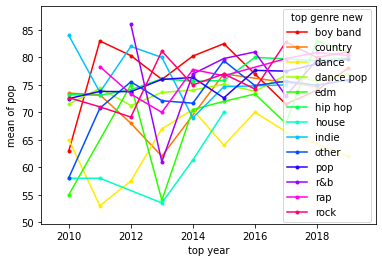

In [3]:
# Interactions between top year and top genre new
fig = interaction_plot(
    x=df["top year"],
    trace=df["top genre new"],
    response=df["pop"],
    legendloc="right",
)

Since some of the lines touch each other, there is a sign of an interaction effect between top year and top genre.

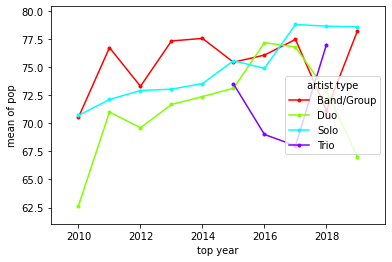

In [4]:
# Interactions between top year and artist type
fig = interaction_plot(
    x=df["top year"],
    trace=df["artist type"],
    response=df["pop"],
    legendloc="right",
)

Since some of the lines touch each other, there is a sign of an interaction effect between top year and artist type.

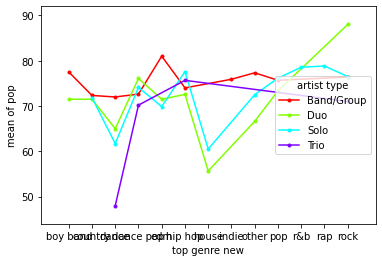

In [5]:
# Interactions between top genre new and artist type
fig = interaction_plot(
    x=df["top genre new"],
    trace=df["artist type"],
    response=df["pop"],
    legendloc="right",
)

Since some of the lines touch each other, there is a sign of an interaction effect between top genre and artist type.

### Normality Assumption

In [6]:
# to avoid errors when creating ols model
df = df.rename(columns={"top year": "top_year", "top genre new": "top_genre_new", "artist type": "artist_type"})
df.head()

,title,artist,top genre,year released,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top_year,artist_type,top_genre_new
0,STARSTRUKK (feat. Katy Perry),3OH!3,dance pop,2009.0,2022‑02‑17,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo,dance pop
1,My First Kiss (feat. Ke$ha),3OH!3,dance pop,2010.0,2022‑02‑17,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo,dance pop
2,I Need A Dollar,Aloe Blacc,pop soul,2010.0,2022‑02‑17,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo,pop
3,Airplanes (feat. Hayley Williams of Paramore),B.o.B,atl hip hop,2010.0,2022‑02‑17,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo,hip hop
4,Nothin' on You (feat. Bruno Mars),B.o.B,atl hip hop,2010.0,2022‑02‑17,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo,hip hop


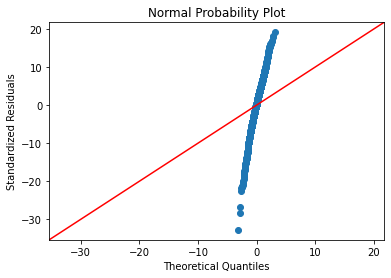

In [7]:
# building the model with the interaction terms
model = ols("pop ~ bpm + nrgy + dnce + dB + live + val + dur + acous + spch + C(top_year) + C(artist_type) + C(top_genre_new) + C(top_year):C(top_genre_new) + C(top_year):C(artist_type) + C(top_genre_new):C(artist_type)", data=df).fit()

# creating the normal probability plot
sm.qqplot(model.resid, line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title("Normal Probability Plot")
plt.show()

The points don't follow the line at all, with large quantiles (positive and negative) indicating heavy tails in the data's distribution. The data violates the normality assumption.

#### Box Cox Transformation (Method #1)

We will try performing a BoxCox transformation of the non-normal dependent variable (pop) in an effort to improve the data's compliance to the normality assumption.

In [8]:
# reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html
transformed_data, lambda_val = boxcox(df['pop'])
df.insert(15, "pop_transformed", transformed_data)

Now that we have transformed the data, let us recheck the normality assumption.

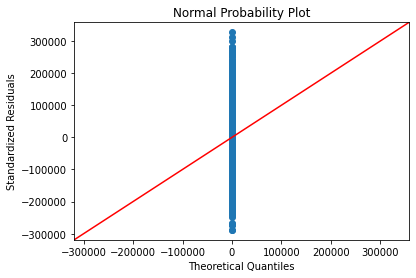

In [9]:
# re-building the model with the interaction terms
model2 = ols("pop_transformed ~ bpm + nrgy + dnce + dB + live + val + dur + acous + spch + C(top_year) + C(artist_type) + C(top_genre_new) + C(top_year):C(top_genre_new) + C(top_year):C(artist_type) + C(top_genre_new):C(artist_type)", data=df).fit()

# re-creating the normal probability plot
sm.qqplot(model2.resid, line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title("Normal Probability Plot")
plt.show()

Using scipy.stats.boxcox dramatically worsened our data's compliance to the normality assumption. This could be due to many reasons, one being that we did not choose the optimal lambda value for the BoxCox transformation. To resolve this doubt, we can use the PowerTransformer from sklearn.preprocessing to find the optimal lambda value, as well as transform our data accordingly.

#### BoxCox Transformation (Method #2)

In [10]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
pt = PowerTransformer(method="yeo-johnson")
pop_df = pd.DataFrame(df["pop"])
pt.fit(pop_df)
print(pt.lambdas_)  # optimal lambda value

[3.27087407]


The above output is the optimal lambda value for the Box Cox transformation of our data. We will use it to transform the `pop` column and update our model.

In [11]:
# transform the score column
transformed_data = pt.transform(pop_df)
df.insert(16, "pop_transformed2", transformed_data)  # new column of transformed score

Now that we have transformed the data again, let us recheck the assumptions.

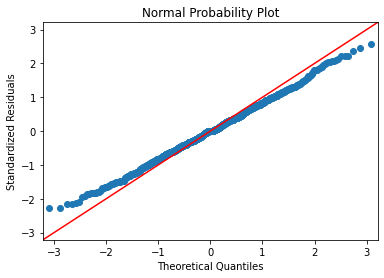

In [12]:
# re-building the model with the interaction term
model3 = ols("pop_transformed2 ~ bpm + nrgy + dnce + dB + live + val + dur + acous + spch + C(top_year) + C(artist_type) + C(top_genre_new) + C(top_year):C(top_genre_new) + C(top_year):C(artist_type) + C(top_genre_new):C(artist_type)", data=df).fit()

# re-creating the normal probability plot
sm.qqplot(model3.resid, line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title("Normal Probability Plot")
plt.show()

In general, the points seem to fall into a relatively straight line on the plot. Points at both ends of the y=x line deviate; however, the transformed data complies with the normality assumption better than the original pop data. We will proceed with the Shapiro-Wilk's test.

#### Shapiro-Wilk's Test
We will also perform a Shapiro-Wilk's test to quantify the ability to accept/reject the normality assumption.

In [13]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
w, pvalue = stats.shapiro(model3.resid)
print(w, pvalue)

0.9982758164405823 0.417789489030838


Since the p-value of 0.417789489030838 is greater than $\alpha$ = 0.05, we fail to reject the null hypothesis. There is stiatistically significant evidence to suggest that the normality assumption holds.

Lastly, we will use a histogram to visualize that the residuals are approximately normally distributed.

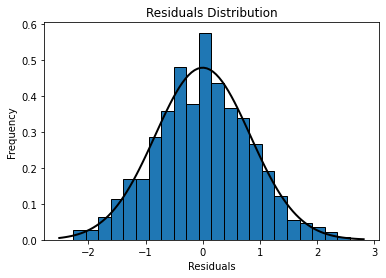

In [14]:
# Reference: https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data

# plot the residuals as a histogram
plt.hist(model3.resid, bins="auto", density=True, histtype="bar", ec="k")
mu, std = norm.fit(model3.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

### Homoscedasticity Assumption

To visualize our data's compliance to the homoscedasticity assumption, we will evaluate the residuals vs. fitted plot, as well as the Scale-Location plot. This plot displays the model's fitted values vs. square root of the standardized residuals.

Text(0, 0.5, 'Residuals')

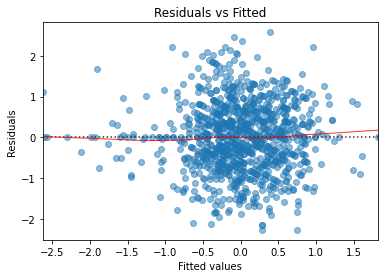

In [15]:
# Reference: https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

# fitted values
model_fitted_y = model3.fittedvalues
# residuals
model_residuals = model3.resid
# normalized residuals
model_norm_residuals = model3.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model3.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model3.get_influence().cooks_distance[0]

# plot details and formatting
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(
    model_fitted_y,
    df.columns[16],
    data=df,
    lowess=True,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red", "lw": 1, "alpha": 0.8},
)

plot_lm_1.axes[0].set_title("Residuals vs Fitted")
plot_lm_1.axes[0].set_xlabel("Fitted values")
plot_lm_1.axes[0].set_ylabel("Residuals")

The "Residuals vs Fitted" graph has a relatively straight horizontal line around zero, so the linearity assumption holds pretty well. The graph has a scale of 2, and the points are randomly and evenly spread out around the line.

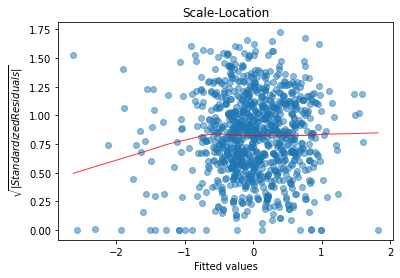

In [16]:
# Reference: https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

# plot details and formatting
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(
    model_fitted_y,
    model_norm_residuals_abs_sqrt,
    scatter=False,
    ci=False,
    lowess=True,
    line_kws={"color": "red", "lw": 1, "alpha": 0.8},
)
plot_lm_3.axes[0].set_title("Scale-Location")
plot_lm_3.axes[0].set_xlabel("Fitted values")
plot_lm_3.axes[0].set_ylabel("$\sqrt{|Standardized Residuals|}$")

# absolute normalized residuals
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)

# top 3 normalized residuals
abs_norm_resid_top_3 = abs_norm_resid[:3]

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(
        i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i])
    )

In the "Scale-Location" graph, the points are randomly and evenly spread out around the red line. The only concern is that the line is slightly bent from the left side. Regardless, the assumption for equal variance holds decently under the observations from these two plots.

#### Levene's Test

We will also perform Levene's test check if the ten top years have equal variances in song popularity scores.

In [17]:
# for some reason, this didn't translate to the cleaned df so manually converting now
df['top_year'] = df['top_year'].astype(str)

In [18]:
# reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
stat, p = levene(
    df[df["top_year"] == "2010.0"]["pop_transformed2"],
    df[df["top_year"] == "2011.0"]["pop_transformed2"],
    df[df["top_year"] == "2012.0"]["pop_transformed2"],
    df[df["top_year"] == "2013.0"]["pop_transformed2"],
    df[df["top_year"] == "2014.0"]["pop_transformed2"],
    df[df["top_year"] == "2015.0"]["pop_transformed2"],
    df[df["top_year"] == "2016.0"]["pop_transformed2"],
    df[df["top_year"] == "2017.0"]["pop_transformed2"],
    df[df["top_year"] == "2018.0"]["pop_transformed2"],
    df[df["top_year"] == "2019.0"]["pop_transformed2"], 
)
print(stat, p)

1.6522907826763027 0.09622805208973675


Since the p-value of 0.09622805208973675 is greater than $\alpha$ = 0.05, we fail to reject the null hypothesis. There is stiatistically significant evidence to suggest that the top years have equal variance.

We will also perform Levene's test check if the thirteen top genres have equal variances in song popularity scores.

In [19]:
# reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
stat, p = levene(
    df[df["top_genre_new"] == "dance pop"]["pop_transformed2"],
    df[df["top_genre_new"] == "pop"]["pop_transformed2"],
    df[df["top_genre_new"] == "hip hop"]["pop_transformed2"],
    df[df["top_genre_new"] == "other"]["pop_transformed2"],
    df[df["top_genre_new"] == "rap"]["pop_transformed2"],
    df[df["top_genre_new"] == "rock"]["pop_transformed2"],
    df[df["top_genre_new"] == "boy band"]["pop_transformed2"],
    df[df["top_genre_new"] == "edm"]["pop_transformed2"],
    df[df["top_genre_new"] == "r&b"]["pop_transformed2"],
    df[df["top_genre_new"] == "dance"]["pop_transformed2"],
    df[df["top_genre_new"] == "country"]["pop_transformed2"],
    df[df["top_genre_new"] == "indie"]["pop_transformed2"],
    df[df["top_genre_new"] == "house"]["pop_transformed2"],
)
print(stat, p)

1.7764492647996273 0.04756946781428622


Since the p-value of 0.04756946781428622 is less than $\alpha$ = 0.05, we reject the null hypothesis. There is stiatistically significant evidence to suggest that the top genres do not have equal variance.

We will also perform Levene's test check if the four artist types have equal variances in song popularity scores.

In [20]:
# reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
stat, p = levene(
    df[df["artist_type"] == "Solo"]["pop_transformed2"],
    df[df["artist_type"] == "Duo"]["pop_transformed2"],
    df[df["artist_type"] == "Trio"]["pop_transformed2"],
    df[df["artist_type"] == "Band/Group"]["pop_transformed2"],
)
print(stat, p)

1.526734955044079 0.20595743890568496


Since the p-value of 0.20595743890568496 is greater than $\alpha$ = 0.05, we fail to reject the null hypothesis. There is stiatistically significant evidence to suggest that the artist types have equal variance.

After checking the normality and homoscedasticity assumptions, we will proceed with linear regression. We will also assume independence between observations.

## Linear Regression (SkLearn)

In [21]:
dummies_topyear = pd.get_dummies(df["top_year"])
dummies_topgenre = pd.get_dummies(df["top_genre_new"])
dummies_artistype = pd.get_dummies(df["artist_type"])

In [22]:
X_numerical = df.select_dtypes(include='number')
X_numerical = X_numerical.drop(['year released', 'pop', 'pop_transformed', 'pop_transformed2'], axis=1)
X = pd.concat([X_numerical, dummies_topyear, dummies_topgenre, dummies_artistype], axis=1)
X.head()

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,2010.0,...,indie,other,pop,r&b,rap,rock,Band/Group,Duo,Solo,Trio
0,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,1,...,0,0,0,0,0,0,0,1,0,0
1,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,1,...,0,0,0,0,0,0,0,1,0,0
2,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,1,...,0,0,1,0,0,0,0,0,1,0
3,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,1,...,0,0,0,0,0,0,0,0,1,0
4,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,1,...,0,0,0,0,0,0,0,0,1,0


In [23]:
x_linr = X
y_linr = df.pop_transformed2

In [24]:
model = LinearRegression()
model.fit(x_linr, y_linr)

r_sq = model.score(x_linr, y_linr)

In [25]:
print(
    "R-squared:", r_sq, "\nIntercept:", model.intercept_, "\nCoefficients:", model.coef_
)

R-squared: 0.18006142377340384 
Intercept: 0.15393642195739776 
Coefficients: [ 1.19776521e-05 -1.08263716e-02 -9.84953919e-04  2.13984357e-02
 -5.29117078e-03  4.69877745e-03  1.55230604e-03  1.92275586e-03
 -2.57656140e-03 -4.19263067e-01 -1.26804734e-01 -2.26550853e-01
 -7.84571229e-02 -2.05506737e-02  8.02796375e-03  9.00407498e-03
  2.55857763e-01  2.70114833e-01  3.28621816e-01  2.91183957e-01
 -3.22328480e-01 -7.99911824e-01  1.11369961e-01 -1.73981396e-01
  3.65707433e-01 -1.01705846e+00  1.05573170e-01 -9.32966443e-02
  2.03120331e-01  5.10153162e-01  4.36587775e-01  3.82881012e-01
  2.86194586e-01  4.25622959e-02  1.43392482e-01 -4.72149364e-01]


We have a very low $R^{2}$ score.